# Predictive Telecom Customer Churn using Machine Learning

We attempt to build a predictive model for predicting customers who will churn with less than or exactly 12 months with Telco, their telecom provider.

## Load Cleaned Dataset with Previous Libraries and Notebook

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
customerID          7043 non-null object
gender              7043 non-null object
SeniorCitizen       7043 non-null int64
Partner             7043 non-null object
Dependents          7043 non-null object
tenure              7043 non-null int64
PhoneService        7043 non-null object
MultipleLines       7043 non-null object
InternetService     7043 non-null object
OnlineSecurity      7043 non-null object
OnlineBackup        7043 non-null object
DeviceProtection    7043 non-null object
TechSupport         7043 non-null object
StreamingTV         7043 non-null object
StreamingMovies     7043 non-null object
Contract            7043 non-null object
PaperlessBilling    7043 non-null object
PaymentMethod       7043 non-null object
MonthlyCharges      7043 non-null float64
TotalCharges        7043 non-null object
Churn               7043 non-null object
dtypes: float64(1), int64(2), obj

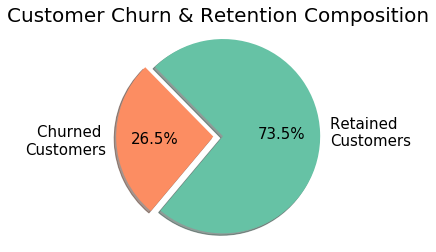

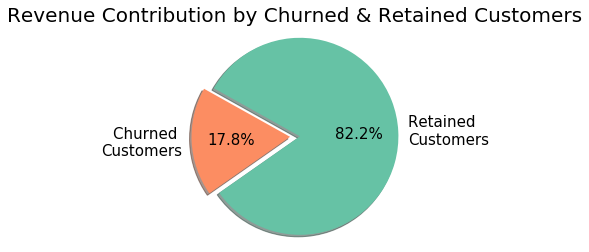

avg churned customer total charge = 1531.8
avg retained customer total charge = 2555.34


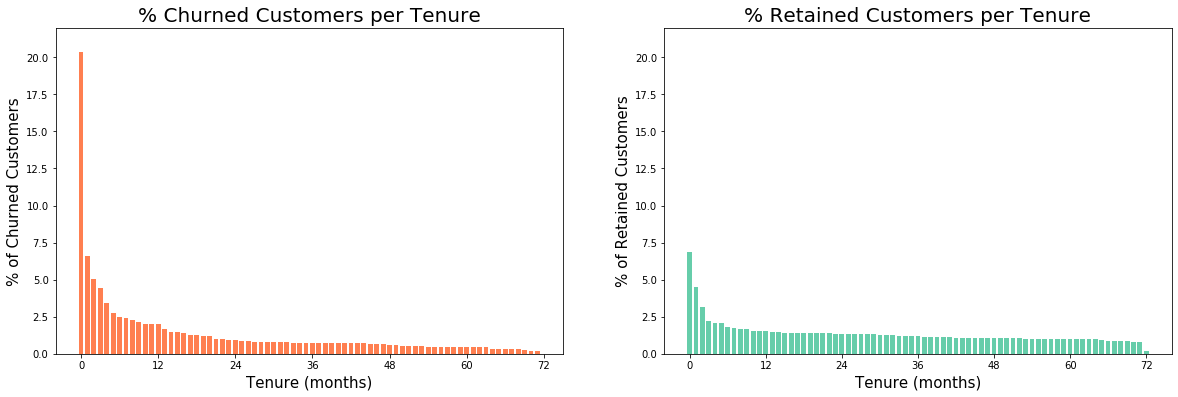

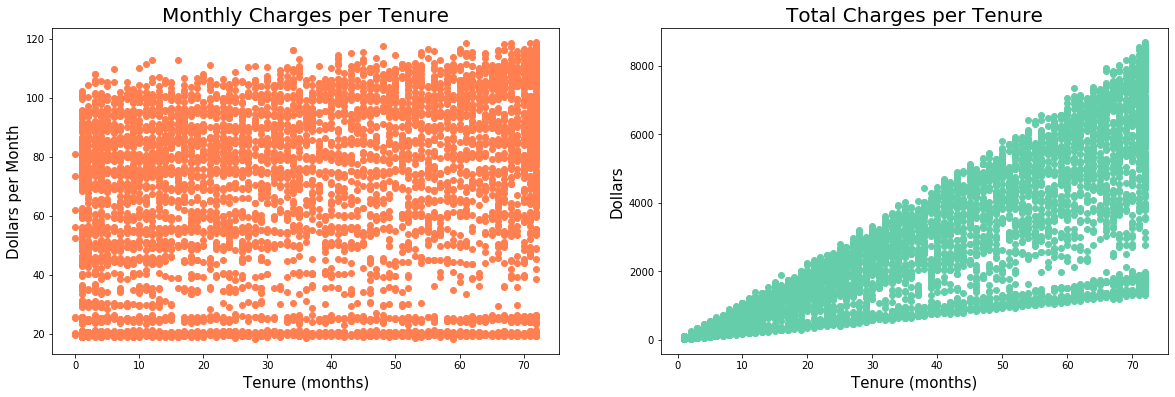

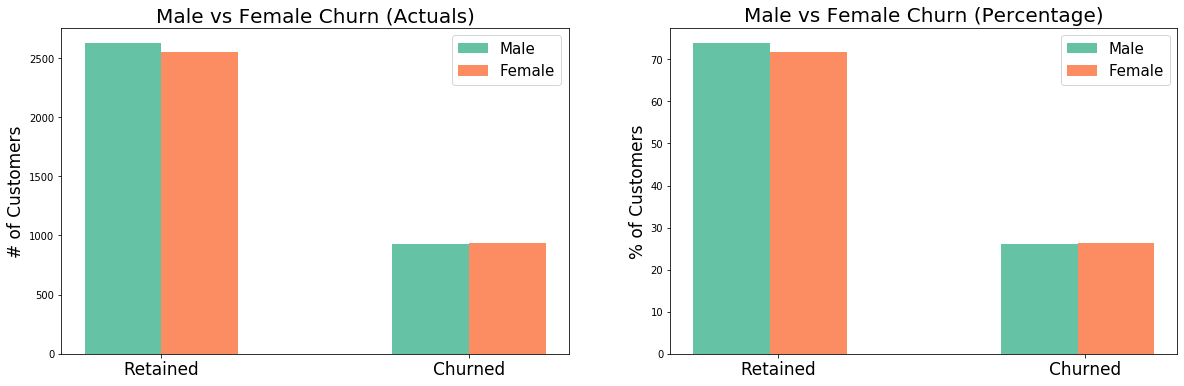

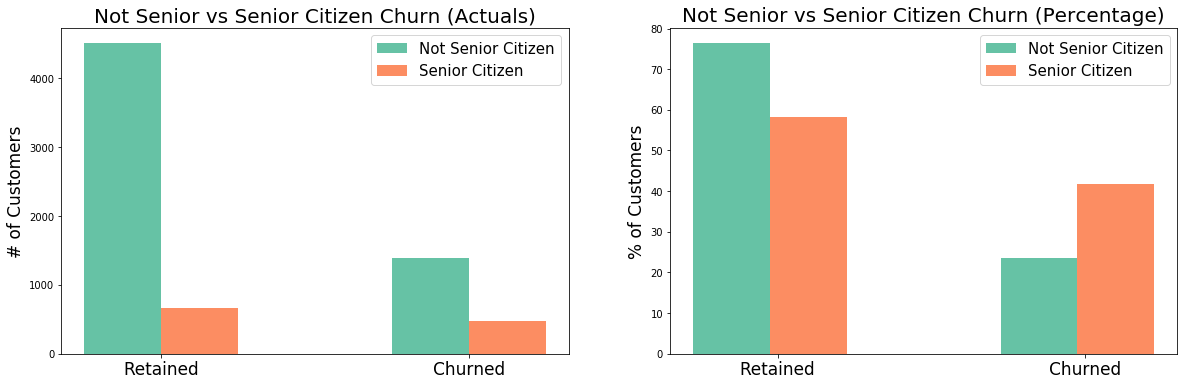

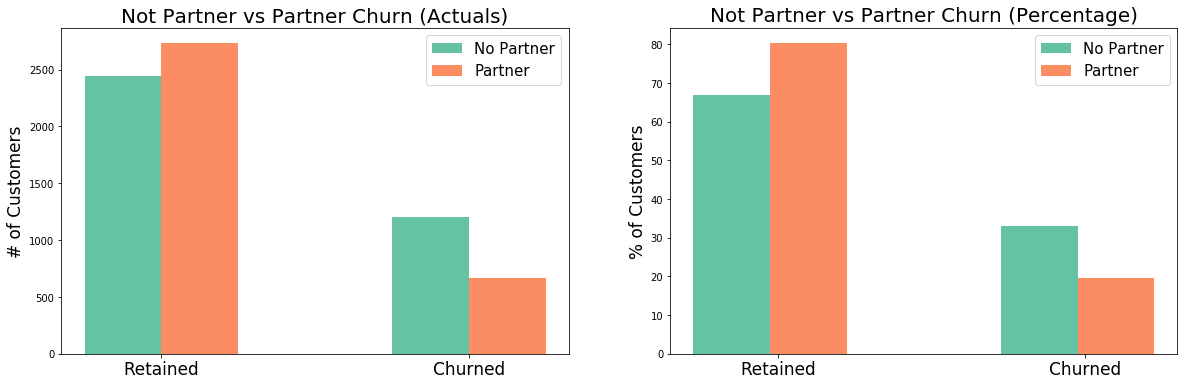

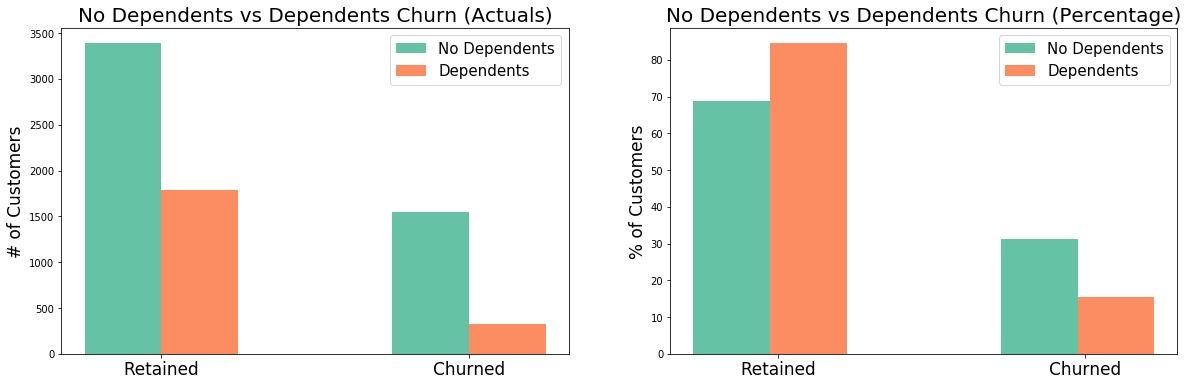

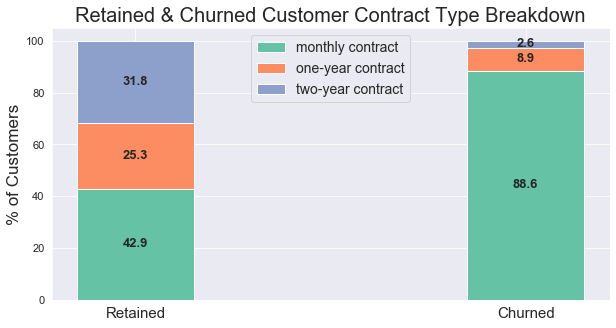

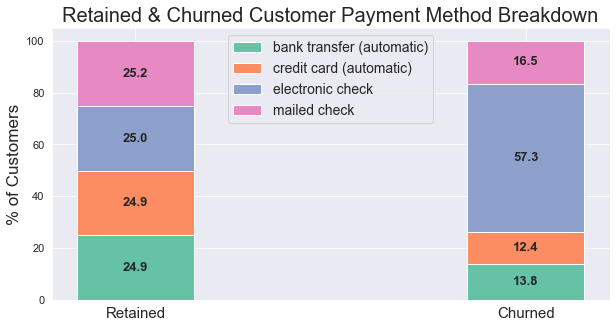

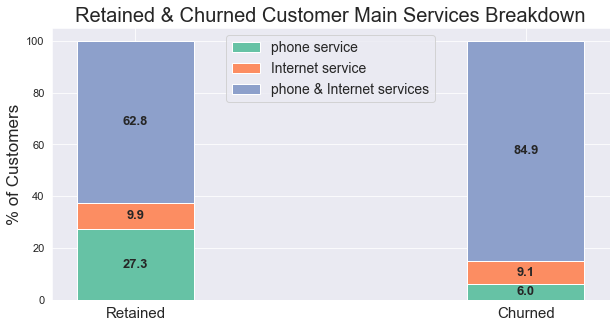

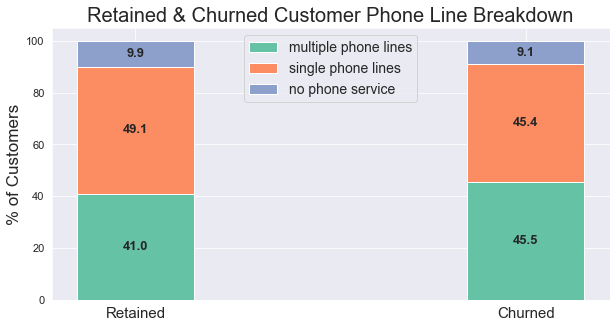

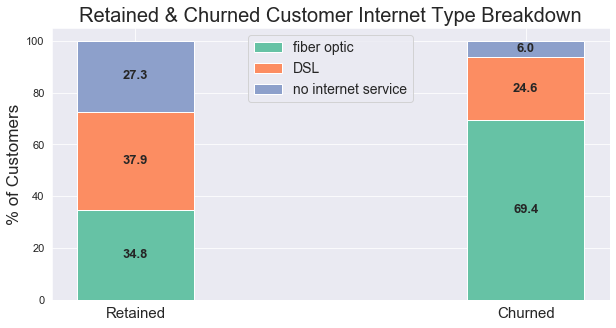

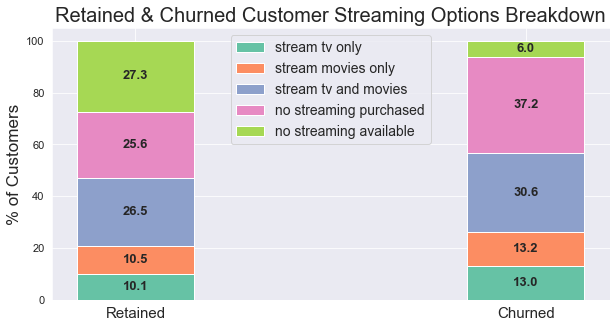

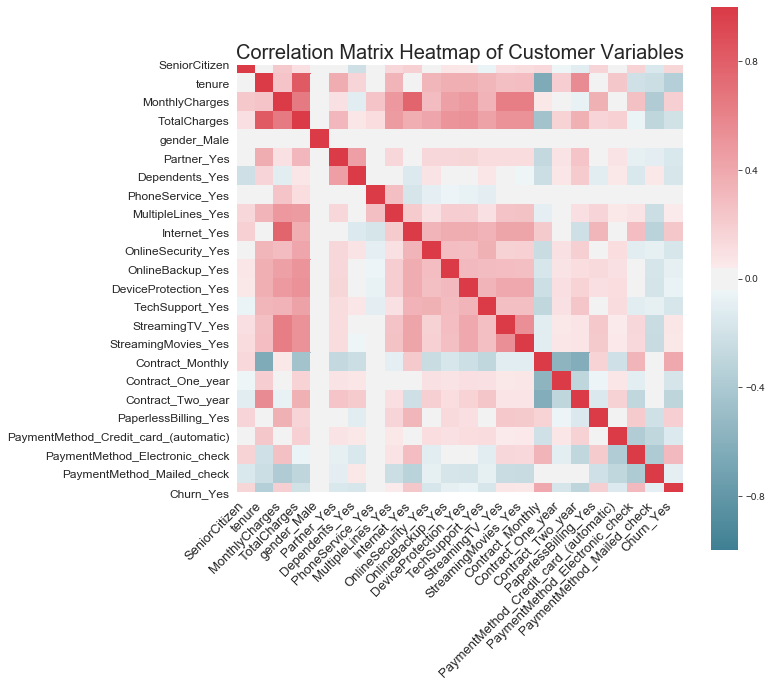

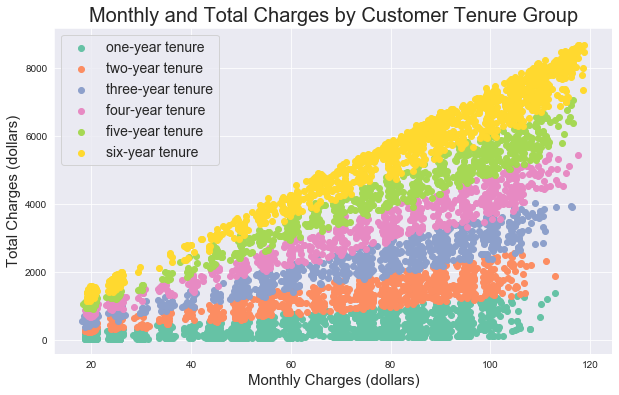

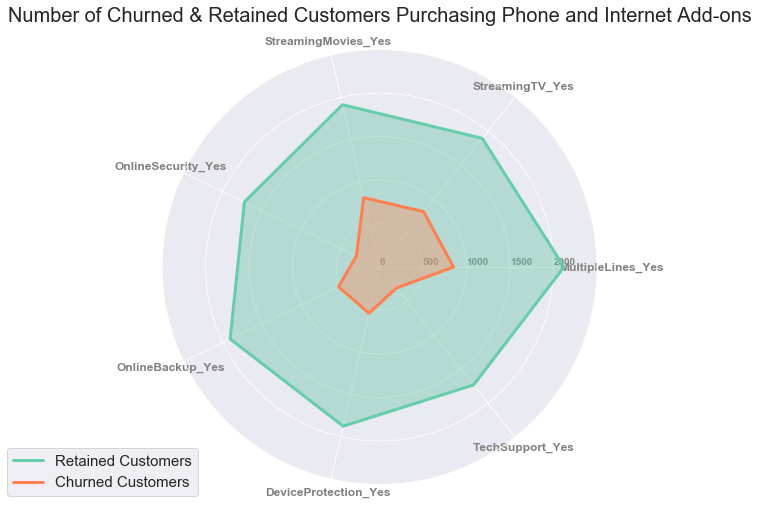

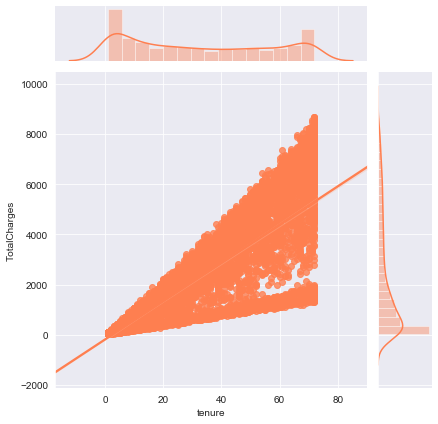

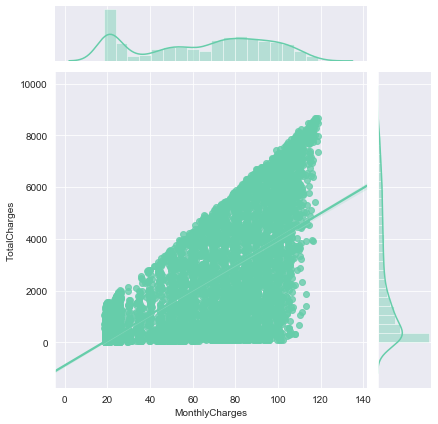

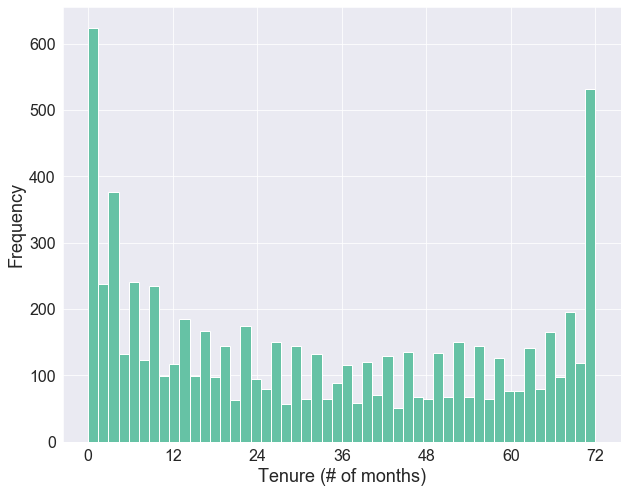

𝐻₀: μ <= 12
𝐻ₐ: μ ≠ 12
The t-statistic is 69.61551026617325
The p-value is 0.0


In [1]:
# Load clean and data-wrangled dataset from previous notebook
%run '/Users/sergiogutierrez/Springboard_projects/Capstone 1/Exploratory Data Analysis (Inferential Statistics) on Telco Data Science Capstone Project.ipynb'

## Data Preprocessing

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
df['DSL_Yes'] = np.where((df.InternetService_Fiber_optic==0) & (df.InternetService_No==0), 1, 0)
df['Tenure_Less_Or_At_12Months'] = np.where((df.tenure <= 12) & (df.Churn_Yes ==1), 1, 0)

model_df = df.rename(columns={'customerID': 'Customer_ID', 'SeniorCitizen': 'SeniorCitizen_Yes', 'tenure': 'Tenure', 
                              'gender_Male': 'Gender_Male','InternetService_Fiber_optic' : 'Fiber_Optic_Yes', 
                              'Contract_Monthly' : 'Contract_Monthly_Yes','Contract_One_year': 'Contract_One_Year_Yes', 
                              'Contract_Two_year': 'Contract_Two_Year_Yes'})

model_df = model_df[model_df.columns.drop(list(df.filter(regex='No'))) 
           & model_df.columns.drop(['PaymentMethod_Credit_card_(automatic)',
                              'PaymentMethod_Electronic_check', 'PaymentMethod_Mailed_check', 
                              'PaperlessBilling_Yes'])]

model_df = model_df.reindex(columns=['Customer_ID', 'Gender_Male', 'SeniorCitizen_Yes', 'Partner_Yes', 'Dependents_Yes', 
                          'PhoneService_Yes','MultipleLines_Yes', 'Internet_Yes', 'DSL_Yes', 'Fiber_Optic_Yes',
                          'OnlineSecurity_Yes', 'OnlineBackup_Yes', 'DeviceProtection_Yes','TechSupport_Yes', 
                          'StreamingTV_Yes', 'StreamingMovies_Yes','Contract_Monthly_Yes', 'Contract_One_Year_Yes',
                          'Contract_Two_Year_Yes', 'MonthlyCharges', 'TotalCharges', 'Churn_Yes', 'Tenure', 'Tenure_Less_Or_At_12Months'])

model_df.fillna(model_df.mean(), inplace=True)

model_df.head()

,Customer_ID,Gender_Male,SeniorCitizen_Yes,Partner_Yes,Dependents_Yes,PhoneService_Yes,MultipleLines_Yes,Internet_Yes,DSL_Yes,Fiber_Optic_Yes,...,StreamingTV_Yes,StreamingMovies_Yes,Contract_Monthly_Yes,Contract_One_Year_Yes,Contract_Two_Year_Yes,MonthlyCharges,TotalCharges,Churn_Yes,Tenure,Tenure_Less_Or_At_12Months
0,7590-VHVEG,0,0,1,0,0,0,1,1,0,...,0,0,1,0,0,29.85,29.85,0,1,0
1,5575-GNVDE,1,0,0,0,1,0,1,1,0,...,0,0,0,1,0,56.95,1889.50,0,34,0
2,3668-QPYBK,1,0,0,0,1,0,1,1,0,...,0,0,1,0,0,53.85,108.15,1,2,1
3,7795-CFOCW,1,0,0,0,0,0,1,1,0,...,0,0,0,1,0,42.30,1840.75,0,45,0
4,9237-HQITU,0,0,0,0,1,0,1,0,1,...,0,0,1,0,0,70.70,151.65,1,2,1


## Snapshot of Customers Churning Within or Exactly 12 Months

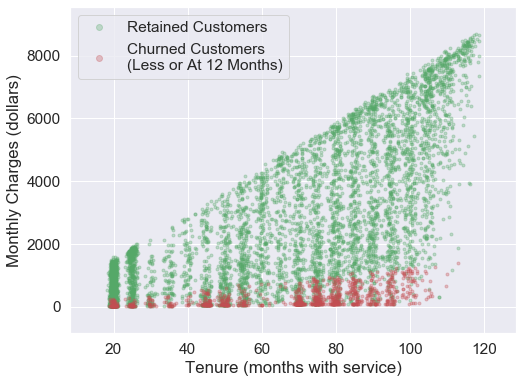

In [4]:
sns.set(font_scale=1.4)

LessOrAt12Months_df = df.loc[df.Tenure_Less_Or_At_12Months==1]
MoreThan12Months_df = df.loc[df.Tenure_Less_Or_At_12Months==0]

plt.figure(figsize=(8,6))
plt.plot(MoreThan12Months_df.MonthlyCharges, MoreThan12Months_df.TotalCharges, marker='.', linestyle='none', alpha=0.3, color='g', label='Retained Customers')
plt.plot(LessOrAt12Months_df.MonthlyCharges, LessOrAt12Months_df.TotalCharges, marker='.', linestyle='none', alpha=0.3, color='r', label='Churned Customers \n(Less or At 12 Months)')

plt.xlabel('Tenure (months with service)')
plt.ylabel('Monthly Charges (dollars)')
plt.legend(markerscale=2, frameon=True)
plt.margins(0.1)

plt.show()

## Train-Test-Split Data

In [5]:
from sklearn.model_selection import train_test_split
from sklearn import preprocessing

X_train, X_test, y_train, y_test = train_test_split(model_df.iloc[:, 1:21].values,
                                                    (model_df.Tenure_Less_Or_At_12Months==1).values, 
                                                    train_size = 0.8, random_state=42)

X_scale_train = preprocessing.scale(X_train)
X_scale_test = preprocessing.scale(X_test)

print("Training set: {}".format(X_train.shape, y_train.shape))
print("Testing set: {}".format(X_test.shape, y_test))

Training set: (5634, 20)
Testing set: (1409, 20)


## Support Vector Machine

In [6]:
from sklearn.svm import SVC
from sklearn.metrics import classification_report

svc = SVC(random_state=42, probability=True, gamma='auto')

svc.fit(X_scale_train, y_train)
svc_y_pred = svc.predict(X_scale_test)

svc_cr_df = pd.DataFrame(classification_report(y_test, svc_y_pred, output_dict=True)).T
svc_cr_df['support'] = svc_cr_df['support'].astype(int)

svc_cr_df.iloc[[0,1,2,4], :]

,precision,recall,f1-score,support
False,0.926341,0.965776,0.945648,1198
True,0.743750,0.563981,0.641509,211
accuracy,0.905607,0.905607,0.905607,0
weighted avg,0.898998,0.905607,0.900103,1409


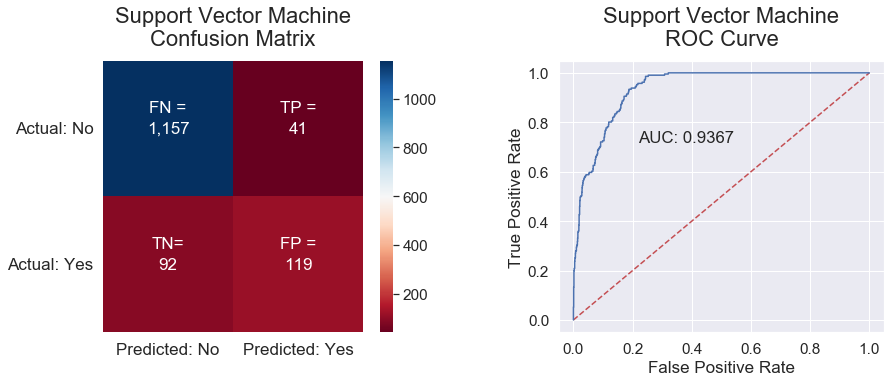

In [152]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

from matplotlib import rcParams
rcParams['axes.titlepad'] = 15 
text_size = 17

svc_confusion_matrix = confusion_matrix(y_test, svc_y_pred)
svc_confusion_matrix.astype(int)
svc_cm_df = pd.DataFrame(svc_confusion_matrix)

figure, ax = plt.subplots(1, 2, figsize=(14, 5))
plt.subplots_adjust(wspace=0.4)

sns.heatmap(svc_cm_df, cmap='RdBu', annot=True, annot_kws={'size':text_size}, fmt=",", ax=ax[0])
ax[0].set_xticklabels(['Predicted: No', 'Predicted: Yes'], ha="center", size=text_size)
ax[0].set_yticks([0,2], minor=True)
ax[0].set_yticklabels(['Actual: No', 'Actual: Yes'], rotation=0, va='center',size=text_size)

ax[0].set_title('Support Vector Machine\nConfusion Matrix', size=22)
ax[0].text(0.5, 1.4, 'TN=', color='w', va='bottom', ha='center', size=text_size)
ax[0].text(0.5, 0.4, 'FN =', color='w', va='bottom', ha='center', size=text_size)
ax[0].text(1.5, 1.4, 'FP =', color='w', va='bottom', ha='center', size=text_size)
ax[0].text(1.5, 0.4, 'TP =', color='w', va='bottom', ha='center', size=text_size)

svc_y_pred_prob = svc.predict_proba(X_scale_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, svc_y_pred_prob)

ax[1].plot([0, 1], [0, 1], 'k--', color='r')
ax[1].plot(fpr, tpr)
ax[1].text(0.22, 0.72, "AUC: {}".format(round(roc_auc_score(y_test, svc_y_pred_prob), 4)))
ax[1].set_xlabel('False Positive Rate', size=text_size)
ax[1].set_ylabel('True Positive Rate', size=text_size)
ax[1].set_title('Support Vector Machine\nROC Curve', size=22)

plt.show()

# Logistic Regression

In [8]:
from sklearn.linear_model import LogisticRegression

lrg = LogisticRegression(random_state=42)

# Fit the model on the trainng data.
lrg.fit(X_train, y_train)
lrg_y_pred = lrg.predict(X_test)

lrg_cr_df = pd.DataFrame(classification_report(y_test, lrg_y_pred, output_dict=True)).T
lrg_cr_df['support'] = lrg_cr_df['support'].astype(int)

lrg_cr_df.iloc[[0,1,2,4], :]

,precision,recall,f1-score,support
False,0.940643,0.952421,0.946495,1198
True,0.709184,0.658768,0.683047,211
accuracy,0.908446,0.908446,0.908446,0
weighted avg,0.905982,0.908446,0.907043,1409


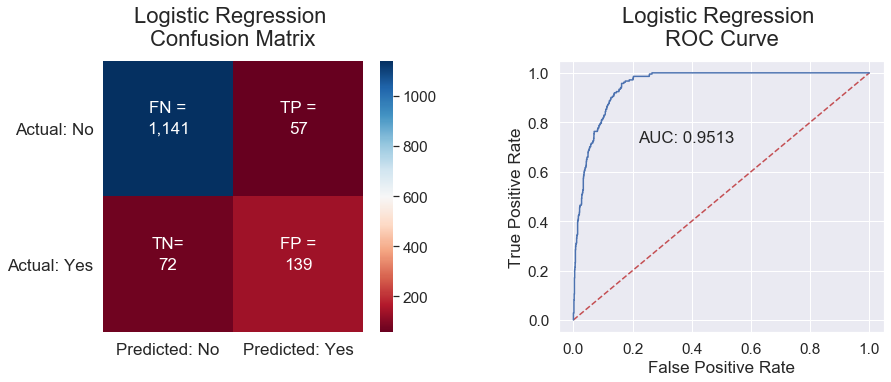

In [153]:
lrg_confusion_matrix = confusion_matrix(y_test, lrg_y_pred)
lrg_confusion_matrix.astype(int)
lrg_cm_df = pd.DataFrame(lrg_confusion_matrix)

figure, ax = plt.subplots(1, 2, figsize=(14, 5))
plt.subplots_adjust(wspace=0.4)

sns.heatmap(lrg_cm_df, cmap='RdBu', annot=True, annot_kws={'size':text_size}, fmt=",", ax=ax[0])
ax[0].set_xticklabels(['Predicted: No', 'Predicted: Yes'], ha="center", size=text_size)
ax[0].set_yticks([0,2], minor=True)
ax[0].set_yticklabels(['Actual: No', 'Actual: Yes'], rotation=360, ha="right", size=text_size)

ax[0].set_title('Logistic Regression \nConfusion Matrix', size=22)
ax[0].text(0.5, 1.4, 'TN=', color='w', va='bottom', ha='center', size=text_size)
ax[0].text(0.5, 0.4, 'FN =', color='w', va='bottom', ha='center', size=text_size)
ax[0].text(1.5, 1.4, 'FP =', color='w', va='bottom', ha='center', size=text_size)
ax[0].text(1.5, 0.4, 'TP =', color='w', va='bottom', ha='center', size=text_size)

lrg_y_pred_prob = lrg.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, lrg_y_pred_prob)

ax[1].plot([0, 1], [0, 1], 'k--', color='r')
ax[1].plot(fpr, tpr)
ax[1].text(0.22, 0.72, "AUC: {}".format(round(roc_auc_score(y_test, lrg_y_pred_prob), 4)))
ax[1].set_xlabel('False Positive Rate', size=text_size)
ax[1].set_ylabel('True Positive Rate', size=text_size)
ax[1].set_title('Logistic Regression \nROC Curve', size=22)

plt.show()

# Random Forest Classifier

In [10]:
from sklearn.ensemble import RandomForestClassifier

rfc = RandomForestClassifier(random_state=42, n_estimators=100)

rfc.fit(X_train, y_train)
rfc_y_pred = rfc.predict(X_test)

rfc_cr_df = pd.DataFrame(classification_report(y_test, rfc_y_pred, output_dict=True)).T
rfc_cr_df['support'] = rfc_cr_df['support'].astype(int)

rfc_cr_df.iloc[[0,1,2,4], :]

,precision,recall,f1-score,support
False,0.928689,0.945743,0.937138,1198
True,0.656085,0.587678,0.620000,211
accuracy,0.892122,0.892122,0.892122,0
weighted avg,0.887866,0.892122,0.889646,1409


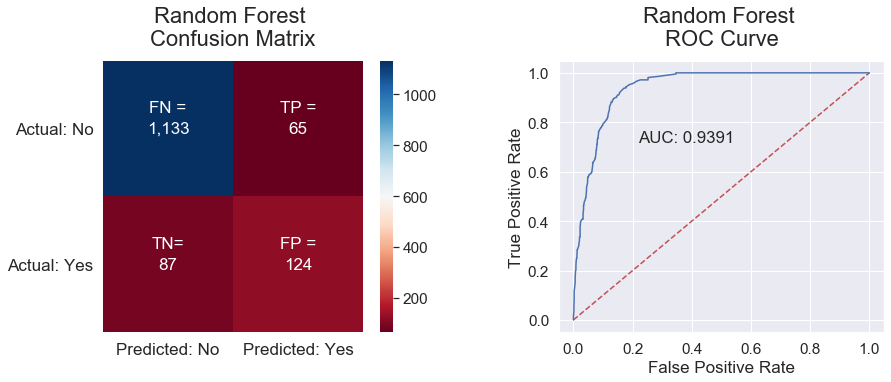

In [154]:
rfc_confusion_matrix = confusion_matrix(y_test, rfc_y_pred)
rfc_confusion_matrix.astype(int)
rfc_cm_df = pd.DataFrame(rfc_confusion_matrix)

figure, ax = plt.subplots(1, 2, figsize=(14, 5))
plt.subplots_adjust(wspace=0.4)

sns.heatmap(rfc_cm_df, cmap='RdBu', annot=True, annot_kws={'size':text_size}, fmt=",", ax=ax[0])
ax[0].set_xticklabels(['Predicted: No', 'Predicted: Yes'], ha="center", size=text_size)
ax[0].set_yticks([0,2], minor=True)
ax[0].set_yticklabels(['Actual: No', 'Actual: Yes'], rotation=360, ha="right", size=text_size)

ax[0].set_title('Random Forest \nConfusion Matrix', size=22)
ax[0].text(0.5, 1.4, 'TN=', color='w', va='bottom', ha='center', size=text_size)
ax[0].text(0.5, 0.4, 'FN =', color='w', va='bottom', ha='center', size=text_size)
ax[0].text(1.5, 1.4, 'FP =', color='w', va='bottom', ha='center', size=text_size)
ax[0].text(1.5, 0.4, 'TP =', color='w', va='bottom', ha='center', size=text_size)

rfc_y_pred_prob = rfc.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, rfc_y_pred_prob)

ax[1].plot([0, 1], [0, 1], 'k--', color='r')
ax[1].plot(fpr, tpr)
ax[1].text(0.22, 0.72, "AUC: {}".format(round(roc_auc_score(y_test, rfc_y_pred_prob), 4)))
ax[1].set_xlabel('False Positive Rate', size=text_size)
ax[1].set_ylabel('True Positive Rate', size=text_size)
ax[1].set_title('Random Forest \nROC Curve', size=22)

plt.show()

# Tuning Parameters for Machine Learning Models

In [155]:
from sklearn.model_selection import GridSearchCV

svc_param_grid = {"kernel": ['linear', 'rbf', 'poly'],
                  "C": np.arange(20, 220, 20)}

svc_cv = GridSearchCV(estimator=svc, param_grid=svc_param_grid, cv=10)

svc_cv.fit(X_scale_train, y_train)

print("Accuracy scores: {}".format(np.around(svc_cv.cv_results_['mean_test_score'], decimals=6)))
print("Best score: {}".format(round(svc_cv.best_score_, 6)))
print("Best score's parameters: {}".format(svc_cv.best_params_))

Accuracy scores: [0.908413 0.901846 0.897764 0.908946 0.896876 0.898474 0.908768 0.896344
 0.896166 0.908768 0.895989 0.897054 0.908768 0.895456 0.896521 0.908768
 0.895634 0.896166 0.908768 0.894391 0.894569 0.908768 0.894924 0.894391
 0.908768 0.894569 0.894569 0.908768 0.894214 0.893859]
Best score: 0.908946
Best score's parameters: {'C': 40, 'kernel': 'linear'}


In [156]:
lrg_param_grid = {"C": np.logspace(-3,4,num=8, dtype='float'), 
                  "penalty": ['l1', 'l2']}

lrg_cv = GridSearchCV(estimator=lrg, param_grid=lrg_param_grid, cv=10)

lrg_cv.fit(X_train, y_train)

print("Accuracy scores: {}".format(np.around(lrg_cv.cv_results_['mean_test_score'], decimals=6)))
print("Best score: {}".format(round(lrg_cv.best_score_, 6)))
print("Best score's parameters: {}".format(lrg_cv.best_params_)) 

Accuracy scores: [0.870252 0.888534 0.895634 0.900603 0.903798 0.905041 0.905218 0.907171
 0.906106 0.906993 0.906106 0.907171 0.906106 0.906993 0.906106 0.906993]
Best score: 0.907171
Best score's parameters: {'C': 1.0, 'penalty': 'l2'}


In [157]:
rfc_param_grid = {'n_estimators': np.arange(25, 375, 25),
                  'max_depth' : np.arange(2, 12, 2)}

rfc_cv = GridSearchCV(estimator=rfc, param_grid=rfc_param_grid, cv=10)

rfc_cv.fit(X_train, y_train)

print("Accuracy scores: {}".format(np.around(rfc_cv.cv_results_['mean_test_score'], decimals=6)))
print("Best score: {}".format(round(rfc_cv.best_score_, 6)))
print("Best score's parameters: {}".format(rfc_cv.best_params_)) 

Accuracy scores: [0.85339  0.85339  0.85339  0.85339  0.85339  0.85339  0.85339  0.85339
 0.85339  0.85339  0.85339  0.85339  0.85339  0.85339  0.889066 0.883032
 0.882499 0.873624 0.870962 0.870607 0.87043  0.86688  0.868655 0.866347
 0.870075 0.870252 0.870607 0.872559 0.899716 0.899539 0.900248 0.899539
 0.899184 0.898829 0.899361 0.899361 0.899006 0.899361 0.899184 0.899361
 0.899184 0.899006 0.905396 0.905573 0.905573 0.905928 0.906283 0.905396
 0.905396 0.905751 0.905928 0.905218 0.905396 0.905928 0.905573 0.905573
 0.906816 0.906816 0.907526 0.907703 0.907171 0.907881 0.906993 0.906993
 0.906283 0.906283 0.907348 0.906283 0.906638 0.907171]
Best score: 0.907881
Best score's parameters: {'max_depth': 10, 'n_estimators': 150}


# Recommendation System

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity
pd.set_option('display.max_columns', 50)

services_df = model_df.iloc[:, 0:16]
recommender_df = pd.pivot_table(services_df, index='Customer_ID')
recommender_df.head()

In [ ]:
cosine = cosine_similarity(recommender_df)
np.fill_diagonal(cosine, 0 )
similarity_with_services =pd.DataFrame(cosine,index=recommender_df.index)
similarity_with_services.columns=recommender_df.index
similarity_with_services.head()

In [ ]:
def find_n_neighbours(df,n):
    order = np.argsort(df.values, axis=1)[:, :n]
    df = df.apply(lambda x: pd.Series(x.sort_values(ascending=False)
           .iloc[:n].index, 
          index=['top{}'.format(i) for i in range(1, n+1)]), axis=1)
    return df

sim_customers_top = find_n_neighbours(similarity_with_services,15)
sim_customers_top.head()

In [ ]:
i = 0

sim_customers = np.append(sim_customers_top.index[i], sim_customers_top.iloc[i, :])

customers_df = model_df.loc[model_df.Customer_ID.isin(sim_customers)].sort_values(by=['Customer_ID'])

def highlight_less_than(s, threshold, column):
    is_max = pd.Series(data=False, index=s.index)
    is_max[column] = s.loc[column] <= threshold
    return ['background-color: yellow' if is_max.any() else '' for v in is_max]

customers_df[customers_df.Churn_Yes==0].style.apply(highlight_less_than, threshold=12, column=['Tenure'], axis=1)